In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import random
import torch.nn as nn
import torch.optim as optim
import os
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchsummary import summary
# from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter
import torchvision

In [2]:

from matplotlib.patches import Rectangle

In [3]:
# Define the Residual Block for the Generator
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        return x + residual

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, stride=1, padding=4)
        self.prelu = nn.PReLU()
        
        # Residual blocks
        self.residual_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(12)])
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Upsampling blocks
        self.upsample1 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1)
       
        self.pixel_shuffle = nn.PixelShuffle(2)
    
        self.conv3 = nn.Conv2d(64, 1, kernel_size=9, stride=1, padding=4)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu(x)
        residual = x
        x = self.residual_blocks(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = x + residual
        x = self.prelu(x)
        x = self.upsample1(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        x = self.conv3(x)
        
        return self.tanh(x)

In [4]:
generator_path = 'models/GAN/checkpoint_epoch_150.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator().to(device)
checkpoint = torch.load(generator_path, map_location=device)
generator.load_state_dict(checkpoint['generator_state_dict'])


C:\Users\achar\AppData\Local\Temp\ipykernel_6576\561958026.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(generator_path, map_location=device)


<All keys matched successfully>

In [ ]:

# Load and preprocess h5 seismic images
def load_test_data(folder_path):
    images = []
    for file in os.listdir(folder_path):
        print(file)
        if file.endswith(".h5"):
            with h5py.File(os.path.join(folder_path, file), 'r') as f:
                data = np.array(f['data'][:])
                images.append(data)
        if file.endswith('.dat'):
            with open(os.path.join(folder_path, file), 'rb') as f:
                data = np.frombuffer(f.read(), dtype=np.float32)
                data=data.reshape(592,400)
                images.append(data)
    return images

def inspect_dat(path, num_values=20, dtype=np.float32):
    with open(path, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=dtype)
    print(data[:num_values])
    print("Total values:", len(data))



# def load_dat(folder_path):
#     data = np.fromfile("lulia_592_400.dat", dtype=np.float32)
#     data=np.reshape(data,(592,400))
#     print(data.shape)
#     return data

# lulia=load_dat('lulia_592_400.dat')
# plt.figure(figsize=(10,10))
# plt.imshow(lulia.T,cmap='gray')


def extract_random_patch(image, patch_size=128,pos=(0,0)):
    """Extracts a single random patch of given size from the image."""
    h, w = image.shape
    # max_x = h - patch_size
    # max_y = w - patch_size
    
    # Randomly select the top-left coordinate for the patch
    # i = random.randint(0, max_x)
    # j = random.randint(0, max_y)
    i,j=pos
    patch = image[i:i+patch_size, j:j+patch_size]
    
    return patch,(i,j)

def process_and_denoise_images(input_folder, output_folder, model):
    input_images = load_test_data(input_folder)
  
    model.eval()
    os.makedirs(output_folder, exist_ok=True)
    
    for item in input_images:
        # print(f"Item: {item}")  # Debugging line to inspect the structure of each element in input_images
        
        image = item  # Unpack the tuple correctly
        # flag=image.shape > (128,128)
        data_max = np.max(image)
        data_min = np.min(image)
        image_patch=image
        # if flag:
        #     image_patch,pos=extract_random_patch(image,pos=(10,50))
        #     print(pos)
        #     i,j=pos
        # else :
        #     image_patch=image
            
        image_normalized = 2*((image_patch - data_min) / (data_max - data_min))-1
        
        image_tensor = torch.tensor(image_normalized).unsqueeze(0).unsqueeze(0).float().cuda()
        print(image_tensor.shape)
        with torch.no_grad():
            denoised_image = model(image_tensor).detach().squeeze().cpu().numpy()
        print(denoised_image.shape)
        # Renormalize output
        denoised_image_renormalized = ((data_max - data_min) * ((denoised_image+1)/2)) + data_min
        
        # Save output image
        # output_path = os.path.join(output_folder, f"denoised_{file}.png")
        # Image.fromarray((denoised_image_renormalized * 255).astype(np.uint8)).save(output_path)
        
        # Display input and output images
        plt.figure(figsize=(5,5))
        plt.imshow(image.T,cmap='seismic')
        # if flag:
        #  plt.gca().add_patch(Rectangle((i, j),128,128, edgecolor='green', linewidth=3, facecolor='none'))
        plt.title("Input Image")
        plt.show()
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(image_normalized.T, cmap='seismic')
        plt.title("Input Image Patch")
        plt.subplot(1, 2, 2)
        plt.imshow(denoised_image_renormalized.T, cmap='seismic')
        plt.title("Denoised Output Image Patch")
        plt.show()



In [42]:

# Define paths
input_folder = "Input_Images/"
output_folder = "Output-i-Imagesmages/"
k3_original_path = "Input_Images/k3_original_240x400.h5"


torch.Size([1, 1, 128, 128])
(256, 256)


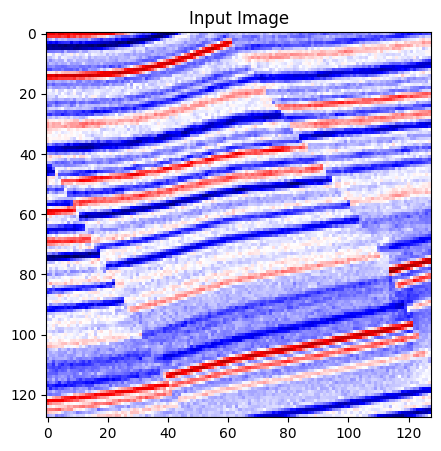

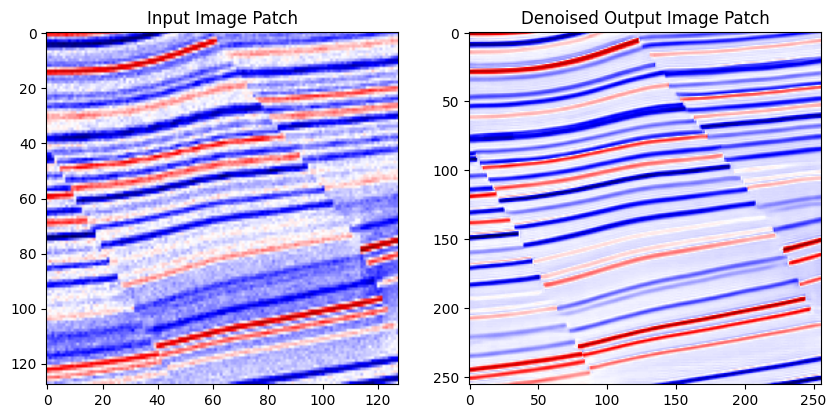

torch.Size([1, 1, 128, 128])
(256, 256)


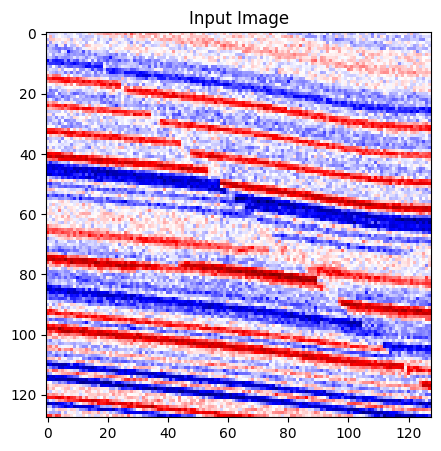

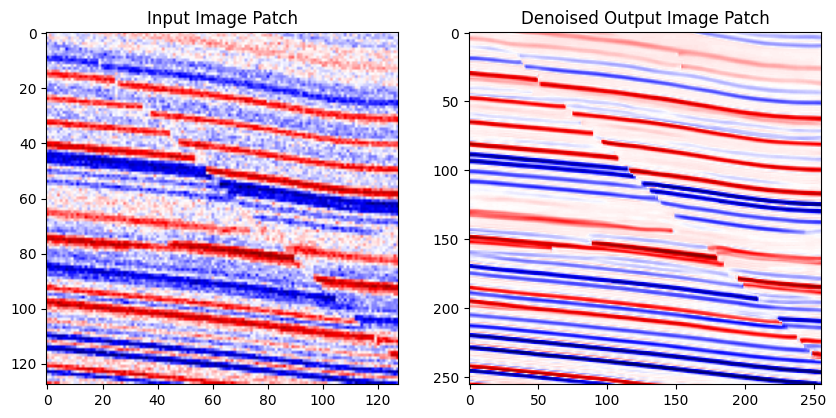

torch.Size([1, 1, 240, 400])
(480, 800)


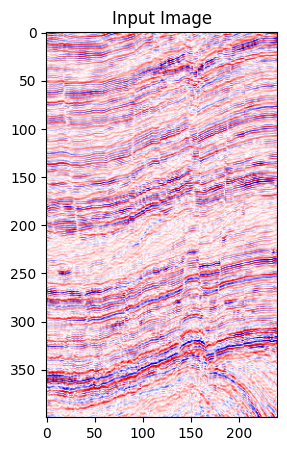

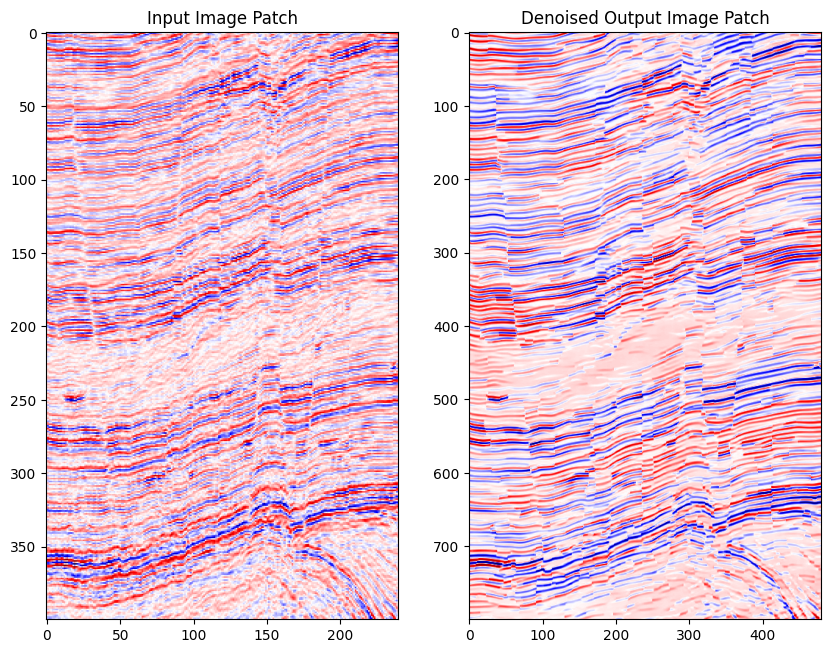

In [43]:

# Process seismic images
process_and_denoise_images(input_folder, output_folder, generator)
